## Mosaik Scenario House that is heated by Sun and PyKnow-based Controller

The scenario of this exercise is in principle a combination of Exc #04 and Hand-in 1b. Here both a battery and controllable heater are available. Instead of heating a tank, we are heating a home, however. Further, there are additional measurements available to the controller: the temperature, the grid export, and the current sunshine level. 

The idea is that the inhabitants prefer radiators to operate less when they can feel the sunshine. The sun-sensor should therefore be used to lower the temperature threshold. At the same time we want to still minimize our energy cost and minimize the export to the grid. Obviously, here there is a contradiction between the goals: can't consumer more heating power when it's supposed not to be warmer. Instead, we introduce the battery from HEMS back into the system.
<img src="./graphics/battery_use_case.svg" width="500">



### Steps:
1. Run the whole notebook and see that the temperature controller is working
2. Open `mosaik_pyknow_control_house.py` and familiarize with it, especially the rules and what happens in the 'step()' function.
3. Run `mosaik_pyknow_control_house.py` from a terminal (using `python mosaik_pyknow_control_house.py`) and test with different input values (see in `__main__()` method.) in order to trigger some rules or others and see how different outputs are generated by the engine. 
4. Modify the rules so that it increases the consumption when electricity is exported. (i.e. Replicate Hand-in 1b Q2.1)
5. Next Modify the rules so that it increases the consumption when electricity is exported. (i.e. Replicate Hand-in 1b Q2.1)

_**NOTE:** You will find comments in the code  indicating what to change._

In [1]:
import pandas as pd
import mosaik
import mosaik.util
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,5]
data_path = 'temp_files/'

In [2]:
# Dictionary with basic configuration of the simulation
basic_conf = {
    'batt_storage_capacity':20,
    'batt_charge_capacity':5,
    'pv1_scaling':1,
    'controller_change_rate':0.9,
    'climate_conditions':'intermittent',
    'random_weather':False,
    'lower_temp_limit': 18, # Minimum comfortable temperature
    'upper_temp_limit': 22, # Maximum comfortable temperature
    'season':'summer'}

# Scenario name which determines the name of the files we will be saving with the results
scenario_name = 'summer_MINE' # <---- MODIFY FILE NAME HERE

In [3]:
SIM_CONFIG = {
    'DemandModel': {
        'python': 'dtu_mosaik.mosaik_demand:DemandModel',
    },
    'SimpleGridModel': {
        'python': 'dtu_mosaik.mosaik_grid:SimpleGridModel',
    },
    'CollectorSim': {
        'python': 'dtu_mosaik.collector:Collector',
    },
    'PVModel': {
        'python': 'dtu_mosaik.mosaik_pv:PVModel'
    },
    'HouseModel': {
        'python': 'dtu_mosaik.mosaik_building:BuildingSim' # Now the house is modeled as house.
    },
    'HeatControl': {
        'python': 'mosaik_pyknow_control_house:Control'
    },
    'BatteryModel': {
        'python': 'dtu_mosaik.mosaik_battery:BatteryModel'
    },
}

# quick check if filepath exists
directory = os.path.dirname(data_path+scenario_name)
if not os.path.exists(directory):
    os.makedirs(directory)

change_rate = basic_conf['controller_change_rate']

seasonscale = {'summer': 1, 'winter': 3, 'autumn': 2, 'spring':2}
demandscale = seasonscale[basic_conf['season']]

ambient_temperatures = {'summer': 16, 'winter': 3, 'autumn': 10, 'spring':10}
ambient_temperature = ambient_temperatures[basic_conf['season']]

pv1_cap = basic_conf['pv1_scaling']
battery_cap = basic_conf['batt_storage_capacity']
battery_rate = basic_conf['batt_charge_capacity']
change_rate = basic_conf['controller_change_rate']
day_type = basic_conf['climate_conditions']
random_weather = basic_conf['random_weather']

seasons = {'summer': 1, 'autumn': 3, 'winter': 5, 'spring': 2}
demand = seasons[basic_conf['season']]

weather_base = {'cloudy': ['/PV715_20180125', '/PV715_20180126', '/PV715_20180127', '/PV715_20180130'],
                'intermittent': ['/PV715_20180423', '/PV715_20180430', '/PV715_20180820', '/PV715_20180722'],
                'sunny': ['/PV715_20180730', '/PV715_20180728', '/PV715_20180729', '/PV715_20180721']}

if random_weather:
    day = weather_base[day_type][np.random.randint(0, 4)]
else:
    day = weather_base[day_type][0]

def init_entities(
        world,
        demandscale=demandscale,
        T_a=ambient_temperature,
        P_maxH=5,
        control_change_rate=basic_conf['controller_change_rate'],
        T_min=basic_conf['lower_temp_limit'],
        T_max=basic_conf['upper_temp_limit'], pv1_rated_capacity=pv1_cap, batt1_rated_cap=battery_cap,
                  batt1_rate=battery_rate, weather=day, 
        filename=data_path+scenario_name):
    sim_dict = {}
    entity_dict = {}
    

    ## Demand
    demand_sim = world.start(
        'DemandModel',
        eid_prefix='demand_',
        step_size=5)
    demand_entity_1 = demand_sim.DemandModel(rated_capacity=demandscale, seriesname='/flexhouse_20180219')
    sim_dict['demand'] = demand_sim
    entity_dict['demand1'] = demand_entity_1

    ## Grid model
    grid_sim = world.start(
        'SimpleGridModel',
        eid_prefix='grid_',
        step_size=5)
    grid_entity_1 = grid_sim.SimpleGridModel(V0=240, droop=0.1)
    
    sim_dict['grid'] = grid_sim
    entity_dict['grid1'] = grid_entity_1

    ##  PV
    pv_sim = world.start(
        'PVModel',
        eid_prefix='pv_',
        step_size=5)
    pv_entity_1 = pv_sim.PVModel(
        rated_capacity=1.0,
        series_name='/PV715_20180730')
    
    sim_dict['pv1'] = pv_sim
    entity_dict['pv1'] = pv_entity_1

    ## House
    house_sim = world.start(
        'HouseModel',
        eid_prefix='house_',
        step_size=5)
    house_entity_1 = house_sim.BuildingSim(
        init_T_amb=T_a,
        init_T_int=20,
        heater_power= P_maxH,
        heat_coeff=30, 
        solar_heat_coeff=1.10,
        insulation_coeff=0.60
        )
        
    sim_dict['house'] = house_sim
    entity_dict['house1'] = house_entity_1
    
    ## Battery
    batt_sim = world.start(
        'BatteryModel',
        eid_prefix='batt_',
        step_size=5)
    batt_entity_1 = batt_sim.BatteryModel(
        rated_capacity=batt1_rated_cap,
        rated_discharge_capacity=batt1_rate,
        rated_charge_capacity=batt1_rate,
        initial_charge_rel=0.5,
        charge_change_rate=0.90)
        
    sim_dict['batt'] = batt_sim
    entity_dict['batt1'] = batt_entity_1
    
    ## Controller
    control_sim = world.start(
        'HeatControl',
        eid_prefix='heatcontrol_',
        step_size=5)
    control_entity_1 = control_sim.Control(
        setpoint_change_rate=control_change_rate,
        T_min=T_min,
        T_max=T_max,
        P_max=P_maxH,
        batt_storage_capacity=batt1_rated_cap,
        rated_discharge_capacity=batt1_rate,
        rated_charge_capacity=batt1_rate,        
        )

    sim_dict['control'] = control_sim
    entity_dict['control1'] = control_entity_1

    ## Collector
    collector_sim = world.start(
        'CollectorSim',
        step_size=60,
        save_h5=True,
        h5_storename='{}_data.h5'.format(filename),
        h5_framename='timeseries/simulation',
        print_results=False)
    
    collector_entity = collector_sim.Collector()
    
    sim_dict['collector'] = collector_sim
    entity_dict['collector'] = collector_entity
    
    return sim_dict, entity_dict


world = mosaik.World(SIM_CONFIG)
sim_dict, entity_dict = init_entities(world)

# Connect units to grid busbar
world.connect(entity_dict['demand1'], entity_dict['grid1'], ('P', 'P'))
world.connect(entity_dict['pv1'], entity_dict['grid1'], ('P', 'P'))
world.connect(entity_dict['batt1'], entity_dict['grid1'], ('P', 'P'))
world.connect(entity_dict['house1'], entity_dict['grid1'], ('P', 'P'))

# Connect PV "sun" to BuildingSim
world.connect(entity_dict['pv1'], entity_dict['house1'], ('zs', 'zs'))

# Connect units to controlller
world.connect(entity_dict['pv1'], entity_dict['control1'], ('zs', 'zs'))
world.connect(entity_dict['grid1'], entity_dict['control1'], ('Pgrid', 'Pgrid'))
world.connect(entity_dict['house1'], entity_dict['control1'], ('T_int', 'T'))
world.connect(entity_dict['control1'], entity_dict['house1'], ('Pset_heat', 'Pset'), time_shifted=True,
                  initial={'Pset_heat': 0.0})
world.connect(entity_dict['control1'], entity_dict['batt1'], ('Pset_batt', 'Pset'), time_shifted=True,
                  initial={'Pset_batt': 0.0})
world.connect(entity_dict['batt1'], entity_dict['control1'], ('relSoC', 'SOC'))


# Connect to Collector
world.connect(entity_dict['demand1'], entity_dict['collector'], ('P', 'DemP[kW]'))
world.connect(entity_dict['grid1'], entity_dict['collector'], ('Pgrid', 'GridP[kW]'))
world.connect(entity_dict['pv1'], entity_dict['collector'], ('P', 'SolarP[kW]'))
world.connect(entity_dict['house1'], entity_dict['collector'], ('P', 'Pheat[kW]'))
world.connect(entity_dict['house1'], entity_dict['collector'], ('T_int', 'HouseTemp[C]'))
world.connect(entity_dict['batt1'], entity_dict['collector'], ('P', 'BattP[kW]'))
world.connect(entity_dict['batt1'], entity_dict['collector'], ('SoC', 'BattSoC[kWh]'))


END = 24*60*60-1 # 24 hours, 1 MosaikTime = 1 second
world.run(END)
## End of simulation

Starting "DemandModel" as "DemandModel-0" ...
{'api_version': '2.3', 'models': {'DemandModel': {'public': True, 'params': ['seriesname', 'rated_capacity'], 'attrs': ['P']}}}
Starting "SimpleGridModel" as "SimpleGridModel-0" ...
{'api_version': '2.3', 'models': {'SimpleGridModel': {'public': True, 'params': ['V0', 'droop'], 'attrs': ['P', 'Pgrid', 'V']}}}
Starting "PVModel" as "PVModel-0" ...
{'api_version': '2.3', 'models': {'PVModel': {'public': True, 'params': ['series_name', 'rated_capacity'], 'attrs': ['P', 'Pav', 'Pmax', 'zs']}}}
Starting "HouseModel" as "HouseModel-0" ...
{'api_version': '2.3', 'models': {'BuildingSim': {'public': True, 'params': ['heat_coeff', 'solar_heat_coeff', 'insulation_coeff', 'init_T_int', 'init_T_amb', 'heater_power'], 'attrs': ['P', 'Pset', 'x', 'T_int', 'zs', 'T_amb']}}}
Starting "BatteryModel" as "BatteryModel-0" ...
{'api_version': '2.3', 'models': {'BatteryModel': {'public': True, 'params': ['rated_capacity', 'rated_charge_capacity', 'rated_discharg

DemandModel-0.demand__0 SimpleGridModel-0.grid__0 PVModel-0.pv__0  \
                     DemP[kW]                 GridP[kW]      SolarP[kW]   
count             1440.000000               1440.000000     1440.000000   
mean                -0.579739                 -0.901496        1.641935   
std                  0.286536                  1.822762        2.014195   
min                 -1.451500                 -6.294000        0.000000   
25%                 -0.759333                 -2.220000        0.000000   
50%                 -0.531833                 -0.002457        0.377500   
75%                 -0.325625                  0.458044        3.346250   
max                 -0.106667                  1.484966        7.109000   

      HouseModel-0.house__0              BatteryModel-0.batt__0               
                  Pheat[kW] HouseTemp[C]              BattP[kW] BattSoC[kWh]  
count           1440.000000  1440.000000            1440.000000  1440.000000  
mean              -0.104011    20.109647              -0.056690    10.679095  
std                0.183953     2.745635               0.436558     1.715079  
min               -0.494713    18.091537              -0.500000     8.030824  
25%               -0.049136    18.101487              -0.500000     9.094522  
50%               -0.004541    18.109336              -0.410000    10.669452  
75%                0.000000    22.132223               0.400000    12.304888  
max                0.000000    26.451062               0.400000    13.335269

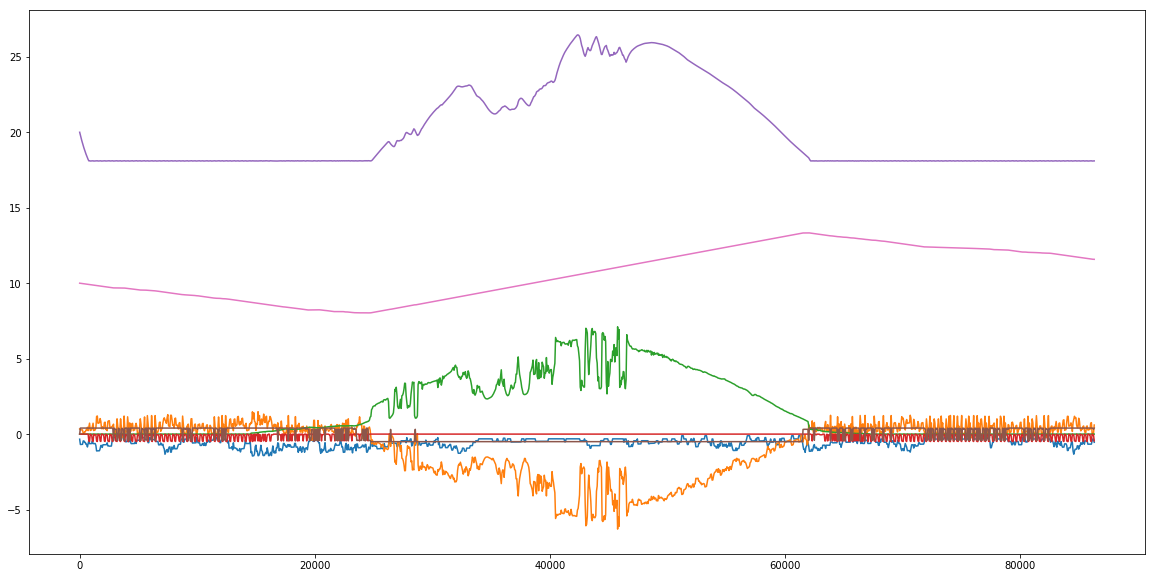

In [4]:
df = pd.HDFStore('temp_files/summer_MINE_data.h5')['timeseries/simulation']
plt.rcParams['figure.figsize'] = [20,10]
df.plot(legend=False)
df.describe()

In [5]:
grid_balance = df['SimpleGridModel-0.grid__0']
energy_imported = grid_balance.apply(lambda x: x[x > 0].sum()) / 60
energy_exported = grid_balance.apply(lambda x: x[x < 0].sum()) / 60

print('The total energy imported over the day is {} [kWh]'.format(energy_imported[0]))
print('The total energy exported over the day is {} [kWh]'.format(energy_exported[0]))



The total energy imported over the day is 6.053176709184483 [kWh]
The total energy exported over the day is -27.68907123786186 [kWh]


In [6]:
HTemps = df['HouseModel-0.house__0']
Tmin=basic_conf['lower_temp_limit']
Tmax=basic_conf['upper_temp_limit']
violateUp= HTemps.apply(lambda x: x[x > Tmax].count())[1]
violateTUp= HTemps.apply(lambda x: x[x > Tmax].max())[1]
#print(HTemps.apply(lambda x: x[x < Tmin]))
#HTemps.apply?
violateDown=HTemps.apply(lambda x: x[x < Tmin].count())[1]
violateTDown= HTemps.apply(lambda x: x[x < Tmin].min())[1]
print('Upper Temperature bound violated for {} [min] with max {} [C]'.format(violateUp*5/60,violateTUp ))
print('Lower Temperature bound violated for {} [min] with min {} [C]'.format(violateDown*5/60,violateTDown))

heatEnergy= -1*HTemps.apply(lambda x: x[x < 0].sum())[0]/60
print('The total energy used for heating over the day is {} [kWh]'.format(heatEnergy))


Upper Temperature bound violated for 31.083333333333332 [min] with max 26.4510616377853 [C]
Lower Temperature bound violated for 0.0 [min] with min nan [C]
The total energy used for heating over the day is 2.496260339577652 [kWh]


In [7]:
print(df.keys)

<bound method NDFrame.keys of       DemandModel-0.demand__0 SimpleGridModel-0.grid__0 PVModel-0.pv__0  \
                     DemP[kW]                 GridP[kW]      SolarP[kW]   
0                   -0.338000                  0.338000             0.0   
60                  -0.687000                  0.287000             0.0   
120                 -0.683167                  0.283167             0.0   
180                 -0.679500                  0.279500             0.0   
240                 -0.678167                  0.278167             0.0   
300                 -0.454167                  0.054167             0.0   
360                 -0.454167                  0.054167             0.0   
420                 -0.552500                  0.152500             0.0   
480                 -0.550833                  0.150833             0.0   
540                 -0.678833                  0.278833             0.0   
600                 -0.677833                  0.277833             0.